In [ ]:
########now part 2: decode and train#######

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3625252946920903512
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11272650752
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3594027441480131163
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [2]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import numpy as np
import pandas as pd
import math
import timeit
import matplotlib.pyplot as plt
from tensorflow.contrib.layers.python.layers import utils
#from preprocess_func_new import *
from matplotlib.image import imread
import os
from os.path import expanduser
# from tensorflow.python import keras
# from tensorflow.keras.applications.mobileNet import DepthwiseConv2D

%matplotlib inline

#tf.enable_eager_execution()

#tf.logging.set_verbosity(tf.logging.INFO)

Instructions for updating:
Use the retry module or similar alternatives.


In [3]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
img_path = os.path.join('..','datasets','stixels')
img_path

'../datasets/stixels'

In [5]:
percent=2 

In [6]:
tfrec_batch_size=1 #for path name only

In [7]:
batch_size=64

In [8]:
tfrec_train_directory = os.path.join('..','datasets','stixels','train','tfrec_batch_size_'
                                     +str(tfrec_batch_size)+'_precent_'+str(percent))
#### note there is a misspelling "precent"
tfrec_train_directory


'../datasets/stixels/train/tfrec_batch_size_1_precent_2'

In [43]:
#creating a list of paths to train tfrecs:
path_tfrecords_train_lst=[]
path_tfrecords_train = os.path.join(img_path, 'train')
for root, dirs, files in os.walk(tfrec_train_directory):
    for file in files:
        if '.tfrecord' in file:
            path_tfrecords_train_lst.append(os.path.join(tfrec_train_directory,file))
        else:
            print('WARNING: file ' + file + 'looks suspicious. does it belong here?')


In [10]:
#shortening the list for experiments
path_tfrecords_train_lst = path_tfrecords_train_lst[:128]
##################

In [11]:
#params
H=370 
W=24
C=3
img_shape = (H, W, C)
num_classes = 47

In [93]:
def parse(serialized):
    # Define a dict with the data-names and types we expect to
    # find in the TFRecords file.
    # It is a bit awkward that this needs to be specified again,
    # because it could have been written in the header of the
    # TFRecords file instead.
    features = \
        {
            'image': tf.FixedLenFeature([], tf.string),
            'label': tf.FixedLenFeature([], tf.int64)
        }

    # Parse the serialized data so we get a dict with our data.
    parsed_example = tf.parse_single_example(serialized=serialized,
                                             features=features)

    # Get the image as raw bytes.
    image_raw = parsed_example['image']

    # Decode the raw bytes so it becomes a tensor with type.
    #######image = tf.decode_raw(image_raw, tf.int32) ####
    image = tf.image.decode_png(image_raw, channels=3, dtype=tf.uint8) 
    #image = tf.cast(image, tf.int32)

    # The type is now uint8 but we need it to be float.
    
    image = tf.cast(image, tf.float32) ####
    
    # Get the label associated with the image.
    label = parsed_example['label']
    
    
    # The image and label are now correct TensorFlow types.
    return image, label

In [13]:
########## a function to print tensor values
def print_tensor(tensor):
    dataset = tf.data.TFRecordDataset(filenames=[tensor])
    dataset = dataset.map(parse)
    iterator = dataset.make_one_shot_iterator()
    images_batch, labels_batch = iterator.get_next()
    x = {'image': images_batch}
    y = labels_batch
    init_op = tf.initialize_all_variables()

    with tf.Session() as sess:
        sess.run(init_op)
        print (sess.run(y))
        #print (sess.run(x))
        #return(sess.run(x))
    return

In [67]:
################ try to print the tensors
for t in path_tfrecords_train_lst[:128]:
    #print (t)
    print_tensor(t)
    #print(x)

18
19
26
15
17
29
46
15
16
15
14
33
16
30
25
8
21
20
27
32
22
15
31
19
26
9
36
36
16
15
10
24
30
35
10
18
24
16
17
21
36
22
26
10
29
15
20
14
16
12
23
24
38
32
30
23
31
14
16
15
17
17
22
33
12
17
30
13
20
11
35
17
34
11
28
10
15
18
14
46
46
25
16
11
15
16
21
18
33
28
26
11
46
35
24
13
15
10
20
35
21
11
32
27
32
13
21
12
18
35
25
15
21
17
24
26
22
18
19
18
14
29
13
13
22
34
24
17


In [22]:
############# print shape of tensor
x2=tf.Session().run(x['image'])
x2.shape


NameError: name 'x' is not defined

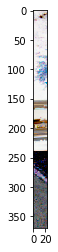

In [107]:
####################. show the parsed stixel
import matplotlib
%matplotlib inline
matplotlib.pyplot.imshow(x2)

In [94]:
def input_fn(filenames, train, batch_size=batch_size, buffer_size=100000): 
    # Args:
    # filenames:   Filenames for the TFRecords files.
    # train:       Boolean whether training (True) or testing (False).
    # batch_size:  Return batches of this size.
    # buffer_size: Read buffers of this size. The random shuffling
    #              is done on the buffer, so it must be big enough.

    # Create a TensorFlow Dataset-object which has functionality
    # for reading and shuffling data from TFRecords files.
    dataset = tf.data.TFRecordDataset(filenames=filenames)

    # Parse the serialized data in the TFRecords files.
    # This returns TensorFlow tensors for the image and labels.
    dataset = dataset.map(parse)
    
    if train:
        # If training then read a buffer of the given size and
        # randomly shuffle it.
        ######dataset = dataset.shuffle(buffer_size=buffer_size)

        # Allow infinite reading of the data.
        num_repeat = None #-1
    else:
        # If testing then don't shuffle the data.
        
        # Only go through the data once.
        num_repeat = 1

    # Repeat the dataset the given number of times.
    dataset = dataset.repeat(num_repeat)
    
    # Get a batch of data with the given size.
    #dataset = dataset.batch(batch_size)
    #dataset = tf.contrib.data.batch_and_drop_remainder(batch_size)
    dataset = dataset.apply(tf.contrib.data.batch_and_drop_remainder(batch_size))
    print('@@@')
    print(dataset.output_shapes)  # ==> "(16,)" (the batch dimension is known)
    print('@@@')
    # Create an iterator for the dataset and the above modifications.
    iterator = dataset.make_one_shot_iterator()

    # Get the next batch of images and labels.
    images_batch, labels_batch = iterator.get_next()

    # The input-function must return a dict wrapping the images.
    x = {'image': images_batch}
    y = labels_batch
    return x, y

In [95]:
def train_input_fn():
    return input_fn(filenames=path_tfrecords_train_lst, train=True)

In [96]:
# the next four cells are a modification of https://github.com/xiaochus/MobileNetV2/blob/master/mobilenet_v2.py
def _conv_block(inputs, filters, kernel, strides, is_training):
    """Convolution Block
    This function defines a 2D convolution operation with BN and relu6.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        strides: An integer or tuple/list of 2 integers,
            specifying the strides of the convolution along the width and height.
            Can be a single integer to specify the same value for
            all spatial dimensions.
    # Returns
        Output tensor.
    """
    x = tf.layers.conv2d(inputs=inputs, 
                         filters=filters, 
                         kernel_size=kernel,
                         activation=None, 
                         strides=strides,
                         kernel_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                         padding='same'
                        )
    
    x = tf.layers.batch_normalization(inputs=x,
                                      training=is_training
                                     )
    
    x = tf.nn.relu6(features=x)
       
    return x


In [97]:
def _bottleneck(inputs, filters, kernel, t, s, is_training, r=False):
    """Bottleneck
    This function defines a basic bottleneck structure.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        t: Integer, expansion factor.
            t is always applied to the input size.
        s: An integer or tuple/list of 2 integers,specifying the strides
            of the convolution along the width and height.Can be a single
            integer to specify the same value for all spatial dimensions.
        r: Boolean, Whether to use the residuals.
    # Returns
        Output tensor.
    """

    
    num_filters_in = utils.last_dimension(inputs.get_shape(), min_rank=4)
    
    # "Expension layer" + BN + activation
    x = _conv_block(inputs=inputs, 
                    filters=num_filters_in*t, 
                    kernel=(1, 1), 
                    strides=(1, 1), 
                    is_training=is_training)
    
    # Depthwise convolution + BN + activation
    x = tf.contrib.layers.separable_conv2d(inputs=x,
                                           num_outputs=None,
                                           kernel_size=kernel,
                                           depth_multiplier=1,
                                           stride=(s,s),
                                           padding='SAME',
                                           activation_fn=tf.nn.relu6,
                                           weights_initializer=tf.contrib.layers.xavier_initializer(seed=481),
                                           normalizer_fn=None
                                          )
     
    x = tf.layers.batch_normalization(inputs=x, 
                                      training=is_training
                                     )
    
    x = tf.nn.relu6(features=x)
    
    # "Projection" layer + BN
    x = tf.layers.conv2d(inputs=x,
                         filters = filters,
                         kernel_size = (1, 1),
                         strides=(1, 1),
                         padding='same',
                         kernel_initializer=tf.contrib.layers.xavier_initializer(seed=481)
                        )
    x = tf.layers.batch_normalization(inputs=x,
                                      training=is_training
                                     )
    
    if r:
        x = tf.add(x, inputs)
        
    '''
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    tchannel = K.int_shape(inputs)[channel_axis] * t
    x = _conv_block(inputs, tchannel, (1, 1), (1, 1))
    x = DepthwiseConv2D(kernel, strides=(s, s), depth_multiplier=1, padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation(relu6)(x)

    x = Conv2D(filters, (1, 1), strides=(1, 1), padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    '''
    
    return x


In [98]:
def _inverted_residual_block(inputs, filters, kernel, t, strides, n, is_training):
    """Inverted Residual Block
    This function defines a sequence of 1 or more identical layers.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        t: Integer, expansion factor.
            t is always applied to the input size.
        s: An integer or tuple/list of 2 integers,specifying the strides
            of the convolution along the width and height.Can be a single
            integer to specify the same value for all spatial dimensions.
        n: Integer, layer repeat times.
    # Returns
        Output tensor.
    """

    x = _bottleneck(inputs=inputs, 
                    filters=filters, 
                    kernel=kernel, 
                    t=t, 
                    s=strides, 
                    is_training=is_training
                   )
        
    for i in range(1, n):
        x = _bottleneck(inputs=x, 
                        filters=filters, 
                        kernel=kernel, 
                        t=t, 
                        s=1, 
                        is_training=is_training, 
                        r=True
                       )

    return x


In [211]:
def MobileNetV2(inputs, k, is_training):
    """MobileNetV2
    This function defines a MobileNetV2 architectures.
    # Arguments
        inputs: A tensor of the input of shape [-1,W,H,C].
        k: Integer, number of classes.
        is_training: boolean indication training or prediction
    # Returns
        MobileNetV2 model.
    """

    
    
    
    x = _conv_block(inputs=inputs, filters=32, kernel=(3, 3), strides=(2, 2), is_training=is_training)
        
    x = _inverted_residual_block(inputs=x, filters=16,  kernel=(7, 3), t=1, strides=1, n=1, is_training=is_training)
    x = _inverted_residual_block(inputs=x, filters=24,  kernel=(7, 3), t=6, strides=2, n=2, is_training=is_training)
    x = _inverted_residual_block(inputs=x, filters=32,  kernel=(7, 3), t=6, strides=2, n=3, is_training=is_training)
    x = _inverted_residual_block(inputs=x, filters=64,  kernel=(7, 3), t=6, strides=2, n=4, is_training=is_training)
    x = _inverted_residual_block(inputs=x, filters=96,  kernel=(7, 3), t=6, strides=1, n=3, is_training=is_training)
#     x = _inverted_residual_block(inputs=x, filters=160, kernel=(3, 3), t=6, strides=2, n=3, is_training=is_training)
#     x = _inverted_residual_block(inputs=x, filters=320, kernel=(3, 3), t=6, strides=1, n=1, is_training=is_training)
    
    # Eventually this should be replaced with:
    x = tf.layers.flatten(x)


    # This is the last layer so it does not use an activation function.
    x = tf.layers.dense(inputs=x, name='layer_fc6',
                          units=k,
                          kernel_initializer=tf.contrib.layers.xavier_initializer()
                          ) 
    '''
    x = _conv_block(inputs=x, filters=1280, kernel=(1, 1), strides=(1, 1), is_training=is_training)
    x = tf.layers.average_pooling2d(inputs=x, pool_size=(2000,2000), strides=(1,1), padding='same')
    x = tf.reshape(x, [-1,1,1,1280])
    #x = tf.layers.dropout(inputs=x, rate=0.3, seed=481, training=is_training)
    x = tf.layers.conv2d(inputs=x,
                         filters = k,
                         kernel_size = (1, 1),
                         padding='same',
                         kernel_initializer=tf.contrib.layers.xavier_initializer(seed=481)
                        )
    '''
    '''
    x = GlobalAveragePooling2D()(x)
    x = Reshape((1, 1, 1280))(x)
    x = Dropout(0.3, name='Dropout')(x)
    x = Conv2D(k, (1, 1), padding='same')(x)
    x = Activation('softmax', name='softmax')(x)
    output = Reshape((k,))(x)
    '''
    

    return x

In [212]:
def model_fn(features, labels, mode, params):
    # Args:
    #
    # features: This is the x-arg from the input_fn.
    # labels:   This is the y-arg from the input_fn.
    # mode:     Either TRAIN, EVAL, or PREDICT
    # params:   User-defined hyper-parameters, e.g. learning-rate.
    
   
    if mode == tf.estimator.ModeKeys.TRAIN:
        is_training = True
    else:
        is_training = False
    
    # Reference to the tensor named "image" in the input-function.    
    x = features["image"]
    # The convolutional layers expect 4-rank tensors
    # but x is a 2-rank tensor, so reshape it.
    inputs = tf.reshape(x, [-1,W,H,C])
    
    net = MobileNetV2(inputs=inputs, k=47, is_training=is_training)
    
    
    
    # Logits output of the neural network.
    logits = net

    # Softmax output of the neural network.
    y_pred = tf.nn.softmax(logits=logits)
    
    # Classification output of the neural network.
    y_pred_cls = tf.argmax(y_pred, axis=1) 
   
    if mode == tf.estimator.ModeKeys.PREDICT:
        # If the estimator is supposed to be in prediction-mode
        # then use the predicted class-number that is output by
        # the neural network. Optimization etc. is not needed.
        
        spec = tf.estimator.EstimatorSpec(mode=mode,
                                          predictions=y_pred_cls)
    else:
        # Otherwise the estimator is supposed to be in either
        # training or evaluation-mode. Note that the loss-function
        # is also required in Evaluation mode.
        
        # Define the loss-function to be optimized, by first
        # calculating the cross-entropy between the output of
        # the neural network and the true labels for the input data.
        # This gives the cross-entropy for each image in the batch.
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels,
                                                                       logits=logits)

        # Reduce the cross-entropy batch-tensor to a single number
        # which can be used in optimization of the neural network.
        tf.argmax(logits)
        #loss = tf.losses.mean_squared_error(labels=labels, predictions=logits)
        loss = tf.reduce_mean(cross_entropy)
#######################
        lr = 1e-4
        step_rate = 5000
        decay = 0.7 #if this equals 1 the lr stays the same

        #global_step = tf.Variable(0, trainable=False)
        #increment_global_step = tf.assign(global_step, global_step + 1)

        learning_rate = tf.train.exponential_decay(lr, global_step=tf.train.get_or_create_global_step(), 
                                           decay_steps=step_rate, decay_rate=decay, staircase=True)
        
        # Define the optimizer for improving the neural network.
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
#         optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate) 
        
        ''' original
        # Get the TensorFlow op for doing a single optimization step.
        train_op = optimizer.minimize(loss=loss, global_step = tf.train.get_or_create_global_step())
        '''
        # for learning parameters of batch normalization:
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            train_op = optimizer.minimize(loss, global_step=tf.train.get_or_create_global_step())
        
        
#############################        


        # Define the evaluation metrics,
        # in this case the classification accuracy.
        metrics = \
        {
            "accuracy": tf.metrics.accuracy(labels, y_pred_cls) #TODO change acc method
        }

        # Wrap all of this in an EstimatorSpec.
        spec = tf.estimator.EstimatorSpec(
            mode=mode,
            loss=loss,
            train_op=train_op,
            eval_metric_ops=metrics)


        tf.summary.scalar("accuracy", metrics["accuracy"][1]) 
        merge_summary_op = tf.summary.merge_all()


            
    return spec

In [101]:
params = {} #{"learning_rate": 1e-5}

In [102]:
def make_dir_and_comment(model_dir):
    home = expanduser("~")
    log_name=os.path.join('logs/', model_dir + '.txt')
    
    if os.path.isdir(model_dir):
        print('INFO: dir with name ' + model_dir + ' already exist.')
    
    new_comment=input('Please add a comment\n')
    
    if os.path.exists(log_name):
        append_write = 'a' # append if already exists
    else:
        append_write = 'w' # make a new file if not
    
    model_log = open(log_name,append_write)
    model_log.write(home +' : '+ new_comment + '\n')
    model_log.close()
    return



In [213]:
model_dir = './ckpts_28_5_mobilenetV2_partial_midSize10_kernels_varies_midLR' #'./ckpts_<day>_<month>_<architecture>_<main_change>'
make_dir_and_comment(model_dir) 
# model = tf.estimator.Estimator(model_fn=model_fn,
#                                params=params,
#                                model_dir=model_dir)

model = tf.estimator.Estimator(model_fn=model_fn,
                               params=params,
                               model_dir=model_dir,
                               #config=tf.estimator.RunConfig(save_checkpoints_steps=1000, save_summary_steps=100)
                               config=tf.estimator.RunConfig().replace(save_checkpoints_steps=1000,save_summary_steps=10)
                              )

Please add a comment
initial lr=1e-4, decay by 0.7 every 5K steps, all kernels 7X3 except first conv (3X3)
INFO:tensorflow:Using config: {'_session_config': None, '_task_id': 0, '_tf_random_seed': None, '_save_checkpoints_secs': None, '_keep_checkpoint_max': 5, '_is_chief': True, '_log_step_count_steps': 100, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb880907e48>, '_save_summary_steps': 10, '_evaluation_master': '', '_global_id_in_cluster': 0, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_num_worker_replicas': 1, '_master': '', '_model_dir': './ckpts_28_5_mobilenetV2_partial_midSize10_kernels_varies_midLR', '_save_checkpoints_steps': 1000, '_task_type': 'worker'}


In [214]:
model.train(input_fn=train_input_fn, steps=20000)

@@@
(TensorShape([Dimension(64), Dimension(None), Dimension(None), Dimension(3)]), TensorShape([Dimension(64)]))
@@@
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into ./ckpts_28_5_mobilenetV2_partial_midSize10_kernels_varies_midLR/model.ckpt.
INFO:tensorflow:loss = 6.6833677, step = 0
INFO:tensorflow:global_step/sec: 3.67347
INFO:tensorflow:loss = 5.6572313, step = 100 (27.224 sec)
INFO:tensorflow:global_step/sec: 4.59258
INFO:tensorflow:loss = 4.275052, step = 200 (21.774 sec)
INFO:tensorflow:global_step/sec: 4.5857
INFO:tensorflow:loss = 3.8936946, step = 300 (21.807 sec)
INFO:tensorflow:global_step/sec: 4.60105
INFO:tensorflow:loss = 3.898177, step = 400 (21.734 sec)
INFO:tensorflow:global_step/sec: 4.5805
INFO:tensorflow:loss = 3.6485536, step = 500 (21

In [115]:
###DONE TRAIN###

In [219]:
#performance on training dataset:
def train_partial_input_fn():
#     return input_fn(path_tfrecords_train_lst[7000:8500], train=False) 
    return input_fn(path_tfrecords_train_lst[183000:184500], train=False) 

train_partial_result = model.evaluate(input_fn=train_partial_input_fn) 

@@@
(TensorShape([Dimension(64), Dimension(None), Dimension(None), Dimension(3)]), TensorShape([Dimension(64)]))
@@@
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-28-15:56:59
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./ckpts_28_5_mobilenetV2_partial_midSize10_kernels_varies_midLR/model.ckpt-20000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-28-15:57:05
INFO:tensorflow:Saving dict for global step 20000: accuracy = 0.3396739, global_step = 20000, loss = 1.9045038


In [ ]:
#VAL:

In [46]:
tfrec_val_batch_size=1

In [47]:
tfrec_val_directory = os.path.join('..','datasets','stixels','val','tfrec_batch_size_'+str(tfrec_val_batch_size))#+'_percent_'+str(percent))

In [48]:
path_tfrecords_val_lst=[]
path_tfrecords_val = os.path.join(img_path, 'val')
for root, dirs, files in os.walk(tfrec_val_directory):
    for file in files:
        if '.tfrecord' in file:
            path_tfrecords_val_lst.append(os.path.join(tfrec_val_directory,file))
        else:
            print('WARNING: file ' + file + 'looks suspicious. does it belong here?')

In [62]:
def val_input_fn():
    return input_fn(path_tfrecords_val_lst[4000:5500], train=False) 

In [220]:
val_result = model.evaluate(input_fn=val_input_fn) 

@@@
(TensorShape([Dimension(64), Dimension(None), Dimension(None), Dimension(3)]), TensorShape([Dimension(64)]))
@@@
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-28-15:57:43
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./ckpts_28_5_mobilenetV2_partial_midSize10_kernels_varies_midLR/model.ckpt-20000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-28-15:57:49
INFO:tensorflow:Saving dict for global step 20000: accuracy = 0.29891303, global_step = 20000, loss = 2.0882943


In [51]:
val_result

{'accuracy': 0.26630434, 'global_step': 100000, 'loss': 2.224182}

In [52]:
print("Classification val accuracy: {0:.2%}".format(val_result["accuracy"]))

Classification val accuracy: 26.63%


In [ ]:
#TEST:

In [162]:
tfrec_test_batch_size=1

In [163]:
tfrec_test_directory = os.path.join('..','datasets','stixels','test','tfrec_batch_size_'+str(tfrec_test_batch_size))

In [164]:
path_tfrecords_test_lst=[]
path_tfrecords_test = os.path.join(img_path, 'test')
for root, dirs, files in os.walk(tfrec_test_directory):
    for file in files:
        if '.tfrecord' in file:
            path_tfrecords_test_lst.append(os.path.join(tfrec_test_directory,file))
        else:
            print('WARNING: file ' + file + 'looks suspicious. does it belong here?')

In [167]:
def test_input_fn():
    return input_fn(filenames=path_tfrecords_test_lst[1000:2500], train=False)

In [221]:
test_result = model.evaluate(input_fn=test_input_fn)

@@@
(TensorShape([Dimension(64), Dimension(None), Dimension(None), Dimension(3)]), TensorShape([Dimension(64)]))
@@@
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-28-15:58:19
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./ckpts_28_5_mobilenetV2_partial_midSize10_kernels_varies_midLR/model.ckpt-20000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-28-15:58:25
INFO:tensorflow:Saving dict for global step 20000: accuracy = 0.18953805, global_step = 20000, loss = 2.6755853


In [109]:
print("Classification test accuracy: {0:.2%}".format(test_result["accuracy"]))

Classification test accuracy: 11.55%


In [ ]:
#PRED:

In [222]:
sum_csv_test_path = os.path.join(img_path,'train', 'sum_csv') #TEST
labels_test=pd.read_csv(os.path.join(sum_csv_test_path,'labels_train_'+str(percent)+'percent.csv'))
test_names_list=list(labels_test['Name'])
image_paths_test=[]
for name in test_names_list:
    image_paths_test.append(os.path.join(img_path, 'train', name+'.png')) #maybe no need to add '.png'


In [223]:
def load_images(image_paths):
    # Load the images from disk.
    images = [imread(path) for path in image_paths]
    # Convert to a numpy array and return it.
    return np.asarray(images)


In [224]:
##TODO:SHUFFLE!
some_num=1500
some_images = load_images(image_paths=image_paths_test[7000:7000+some_num])
some_images_cls = np.array(labels_test['Label'])

In [225]:
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"image": some_images.astype(np.float32)},
    num_epochs=1,
    shuffle=False)

In [232]:
predictions = model.predict(input_fn=predict_input_fn) 

In [206]:
predictions

<generator object Estimator.predict at 0x7fb884129fc0>

In [233]:
cls_pred = np.array(list(predictions))
cls_pred

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./ckpts_28_5_mobilenetV2_partial_midSize10_kernels_varies_midLR/model.ckpt-20000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


array([46, 46, 46, ..., 46, 46, 46])

In [234]:
cls_pred.shape

(1500,)

In [235]:
np.histogram(some_images_cls, bins= [x for x in range(0, 47, 1)])


(array([    0,     5,     5,    21,    71,   313,   150,  1079,  3691,
         6280, 11605, 13872, 16378, 17646, 19292, 18101, 19392, 17603,
        16215, 15047, 14708, 15527, 14560, 14073, 14708, 13082, 13245,
        12922, 10970, 11509, 10997, 10722, 10903,  9856,  9444,  9308,
         7769,  5462,  2876,  1092,   241,    23,     0,     0,     0,
         7815]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]))

In [236]:
np.histogram(cls_pred, bins= [x for x in range(0, 47, 1)])


(array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0, 1500]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]))

In [178]:
cls_pred[67]


array([3.63838133e-08, 5.23802601e-06, 2.41361181e-06, 8.22993752e-06,
       6.88640721e-05, 6.73187096e-05, 1.12743000e-04, 2.48558167e-03,
       2.41161394e-03, 1.98379252e-03, 1.63461361e-03, 3.52152251e-03,
       4.75671981e-03, 8.01659003e-03, 9.75785963e-03, 8.38503707e-03,
       5.74642140e-03, 7.23679783e-03, 7.88456481e-03, 1.14491200e-02,
       1.59071349e-02, 1.35434372e-02, 5.99773182e-03, 4.06883238e-03,
       6.72300300e-03, 8.37637670e-03, 1.83306281e-02, 2.76202224e-02,
       2.98272502e-02, 2.47496460e-02, 1.82593651e-02, 4.35408838e-02,
       2.88887601e-02, 3.89404297e-02, 9.61616039e-02, 1.31164491e-01,
       6.05020821e-02, 3.79621610e-02, 1.50133632e-02, 7.29497289e-03,
       4.58270835e-04, 1.19983735e-04, 5.25741832e-08, 3.36415056e-08,
       4.82108398e-08, 3.18117941e-08, 2.91014105e-01], dtype=float32)

In [202]:
np.argmax(cls_pred,axis=1)


array([46, 46, 46, ..., 46, 46, 46])

In [203]:
np.histogram(np.argmax(cls_pred,axis=1), bins= [x for x in range(0, 47, 1)])

(array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0, 1500]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]))

In [125]:
np.argmax(cls_pred,axis=1).shape

(100,)

In [144]:
np.argmax(cls_pred[1])

46

In [145]:
y_pred_cls = tf.argmax(cls_pred, axis=1) 

In [146]:
y_pred_cls

<tf.Tensor 'ArgMax:0' shape=(100,) dtype=int64>

In [147]:
init_op = tf.initialize_all_variables()
with tf.Session() as sess:
        sess.run(init_op)
        print (sess.run(y_pred_cls))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
[46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46
 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46
 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46
 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46 46
 46 46 46 46]
